In [192]:
#base
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
#keras
import keras.backend as K
import tensorflow as tf 
from tensorflow.keras import losses
#sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr

from scipy.spatial import distance
from sklearn.metrics import mean_squared_error

In [193]:
warnings.filterwarnings('ignore')
sns.set_theme()

In [194]:
%cd /home/MCB/zkarwowska/AE

/home/MCB/zkarwowska/AE


In [195]:
def filter_rare_bacteria(df):
    
    rare_bacteria_df = pd.DataFrame((df == 0).astype(int).sum(axis = 0))
    rare_bacteria_col = rare_bacteria_df[rare_bacteria_df[0] > 250].index
    df_filtered = df.drop(rare_bacteria_col, axis = 1)
    
    return df_filtered

In [36]:
def history_to_df(results):
    
    results_df = pd.DataFrame.from_dict(results.history)
    results_df.columns = ['loss', 'val_loss']
    results_df['epoch'] = results_df.index
    
    return results_df

def plot_history(results_df):
    
    sns.lineplot(x = results_df['epoch'], y = results_df['loss'], color = 'black')
    sns.lineplot(x = results_df['epoch'], y = results_df['val_loss'], color = 'orange', linestyle = '--')
    
    b = mpatches.Patch(color='black', label='train')
    o = mpatches.Patch(color='orange', label='test')

    plt.legend(handles=[b, o], shadow = False)

    plt.show()

In [136]:
def extract_encoder_decoder(latent_layer, latent_dim, model):
    
    #encoder
    encoder_model = tf.keras.Model(input_data, latent_layer)

    #decoder
    encoded_input = tf.keras.Input(shape = (latent_dim))

    decoder = model.layers[-2](encoded_input)
    decoder = model.layers[-1](decoder)
    decoder_model = tf.keras.Model(encoded_input, decoder)

    return encoder_model, decoder_model

def predict_data(encoder_model, decoder_model, input_data):
    
    #predict
    encoded = encoder_model.predict(input_data)
    decoded = decoder_model.predict(encoded)
    decoded_denorm = scaler.inverse_transform(decoded)
    decoded_denorm[decoded_denorm<0] = 0
    decoded_denorm_df = pd.DataFrame(decoded_denorm, columns = filtered_df.columns)
    
    return decoded_denorm_df

In [65]:
def calculate_BC(HISTORY, PREDICTION):
    
    PREDICTION.index = HISTORY.index
    
    BRAY_CURTIS = []

    for idx in HISTORY.index:

        y_true = HISTORY.loc[idx]
        y_forecasted = PREDICTION.loc[idx]

        bray_curtis = distance.braycurtis(y_true,
                                          y_forecasted)

        BRAY_CURTIS.append(bray_curtis)

    bray_curtis_df = pd.DataFrame(BRAY_CURTIS,
                              columns = ['bc_distance'])

    bray_curtis_df['timestep'] = HISTORY.index
    
    return bray_curtis_df

In [123]:
def plot_sample_otu(true, predicted, col):
    
    history_df = true#[1:]
    prediction_df = predicted#[:-1]

    plt.figure(figsize = [20, 5])
    ax = sns.lineplot(x = history_df.index, y = history_df[col], color = 'Black', linewidth = .8, linestyle = '--')
    sns.scatterplot(x = history_df.index, y = history_df[col], color = 'Black', alpha = .7)

    sns.lineplot(x = history_df.index, y = prediction_df[col], color = 'Orange', linewidth = .8)
    sns.scatterplot(x = history_df.index, y = prediction_df[col], color = 'Orange', alpha = .7)

    b = mpatches.Patch(color='black', label='train')
    o = mpatches.Patch(color='orange', label='test')
    plt.legend(handles=[b, o], shadow = False)

    plt.ylabel('sample_otu', fontsize=16)
    #plt.savefig('ae_svar/predictive_autoencoder/sample_otu_test.png')

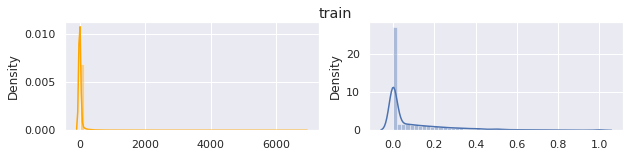

<Figure size 432x288 with 0 Axes>

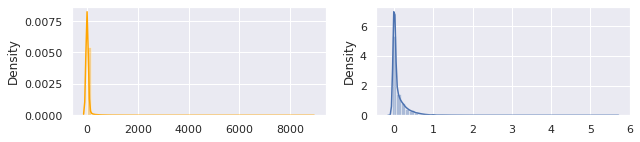

In [196]:
#read data
df = pd.read_csv('rarefied_double_interpolated_feces_male_otu.csv', index_col =[0])
filtered_df = filter_rare_bacteria(df)
filtered_df = filtered_df.drop(['TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGTGCGTAGACGGGAAAACAAGTTAGTTGTGAAATCCCTCGGCTTAACTGAGGAACTG',
                                'TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGAATGCAAGTCAGATGTGAAATCCATGGGCTTAACCCATGAACTG',
                               'TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGAATGCAAGTCAGATGTGAAATCCATGGGCTTAACCCATGAACTG',
                               'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTG'], axis = 1)

#split to train and test
x_train = filtered_df.iloc[:220]
x_test = filtered_df.iloc[221:]
#scale
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(x_train)
normalized_test = scaler.transform(x_test)

#plot distribution after scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 2])
plt.suptitle('train')
ax1 = sns.distplot(x_train, ax = ax1, color = 'orange')
ax2 = sns.distplot(normalized_train, ax = ax2)
plt.show()

plt.suptitle('test')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 2])
ax1 = sns.distplot(x_test, ax = ax1, color = 'orange')
ax2 = sns.distplot(normalized_test, ax = ax2)
plt.show()

# SIMPLE SHALLOW AUTOENCODER MAE LOSS : t --> t'

In [141]:
input_size = normalized_train.shape[1]
input_data = tf.keras.Input(shape=(input_size,))

encoder_layer = tf.keras.layers.Dense(128, activation='relu')
enoded = encoder_layer(input_data)

latent_layer = tf.keras.layers.Dense(32)
latent = latent_layer(enoded)

decoder_layer = tf.keras.layers.Dense(128, activation='relu')
decoded_reconstruction = decoder_layer(latent)

otuput_reconstruction = tf.keras.layers.Dense(input_size)(decoded_reconstruction)
autoencoder = tf.keras.Model(input_data, otuput_reconstruction)

autoencoder.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),   
    optimizer='Adam'
)

ae_result = autoencoder.fit(
    normalized_train, normalized_train,
    epochs=100,
    batch_size=16,
    shuffle=False,
    validation_data=(normalized_test, normalized_test),
    verbose = 0
)



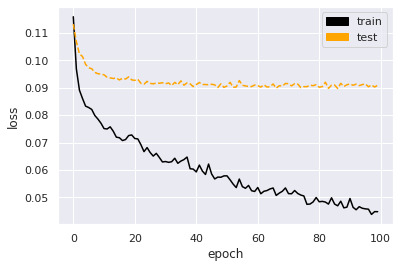

In [133]:
plot_history(history_to_df(ae_result))

In [142]:
reconstruction_encoder, reconstruction_decoder = extract_encoder_decoder(latent, 32, autoencoder)
train_recon = predict_data(reconstruction_encoder, reconstruction_decoder, normalized_train)
test_recon = predict_data(reconstruction_encoder, reconstruction_decoder, normalized_test)

<AxesSubplot:xlabel='data', ylabel='bc_distance'>

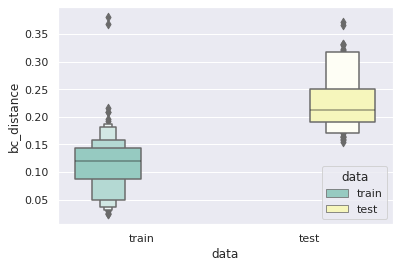

In [143]:
reconstruction_bc_train = calculate_BC(x_train, train_recon)
reconstruction_bc_train['data'] = 'train'
reconstruction_bc_test = calculate_BC(x_test, test_recon)
reconstruction_bc_test['data'] = 'test'

RECONSTRUCTION_BC = reconstruction_bc_train.append(reconstruction_bc_test)

sns.boxenplot(data = RECONSTRUCTION_BC, y = 'bc_distance', x = 'data', hue = 'data', palette = 'Set3')

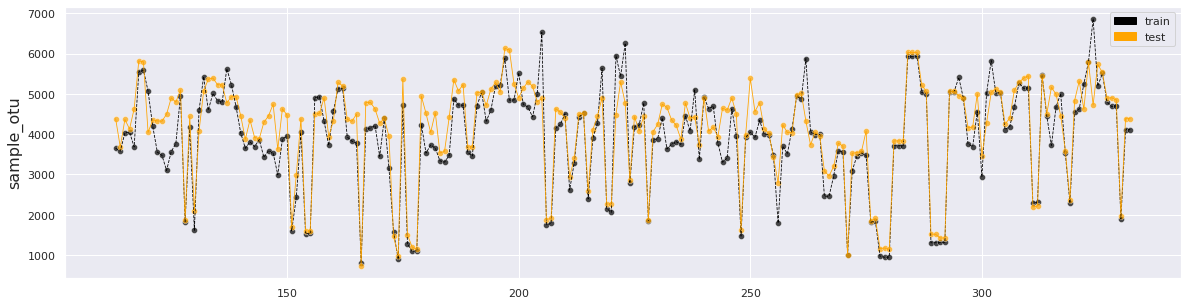

In [139]:
plot_sample_otu(x_train,
                train_recon,
                'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG')

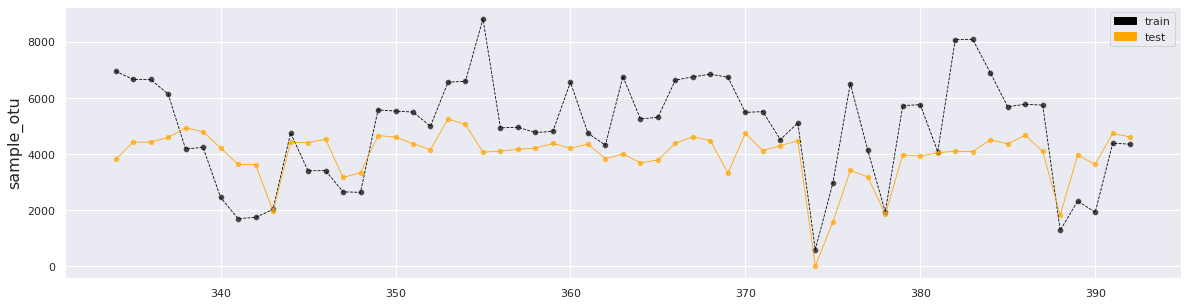

In [140]:
plot_sample_otu(x_test,
                test_recon,
                'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG')

# SIMPLE SHALLOW AUTOENCODER WITH BRAY CURTIS LOSS: t --> t'

In [179]:
class LossBrayCurtis(losses.Loss):

    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossBrayCurtis, self).__init__(name='bray_curtis')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        y_true = (y_true - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = (y_pred - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = tf.nn.relu(y_pred)


        diff = tf.math.abs(y_true - y_pred)
        sum = tf.math.abs(y_true + y_pred)
        value = tf.reduce_sum(diff, axis=-1) / tf.reduce_sum(sum, axis=-1)
        return value

In [145]:
input_size = normalized_train.shape[1]
input_data = tf.keras.Input(shape=(input_size,))

encoder_layer = tf.keras.layers.Dense(128, activation='relu')
enoded = encoder_layer(input_data)

latent_layer = tf.keras.layers.Dense(32)
latent = latent_layer(enoded)

decoder_layer = tf.keras.layers.Dense(128, activation='relu')
decoded_reconstruction = decoder_layer(latent)

otuput_reconstruction = tf.keras.layers.Dense(input_size)(decoded_reconstruction)
bc_autoencoder = tf.keras.Model(input_data, otuput_reconstruction)


BrayCurtisLoss = LossBrayCurtis(None, None)
bc_autoencoder.compile(
    loss = BrayCurtisLoss,   
    optimizer='Adam'
)
bc_autoencoder.run_eagerly = True

bc_ae_result = bc_autoencoder.fit(
    normalized_train, normalized_train,
    epochs=100,
    batch_size=16,
    shuffle=False,
    validation_data=(normalized_test, normalized_test),
    verbose = 0
)

NameError: name 'LossBrayCurtis' is not defined

# SIMPLE SHALLOW PREDICTIVE AUTOENCODER t --> t+1

In [186]:
l2_rate = 1e-5

input_size = normalized_train.shape[1]
input_data = tf.keras.Input(shape=(input_size,))

encoder_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate))
enoded = encoder_layer(input_data)

latent_layer = tf.keras.layers.Dense(32)
latent = latent_layer(enoded)

decoder_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate))
decoded_reconstruction = decoder_layer(latent)

otuput_reconstruction = tf.keras.layers.Dense(input_size)(decoded_reconstruction)
autoencoder = tf.keras.Model(input_data, otuput_reconstruction)

BrayCurtisLoss = LossBrayCurtis(None, None)

autoencoder.compile(
    loss = BrayCurtisLoss,   
    optimizer=tf.keras.optimizers.SGD()
)
bc_autoencoder.run_eagerly = True

ae_result = autoencoder.fit(
    normalized_train[:-1], normalized_train[1:],
    epochs=100,
    batch_size=4,
    shuffle=False,
    validation_data=(normalized_test[:-1], normalized_test[1:]),
    verbose = 0
)

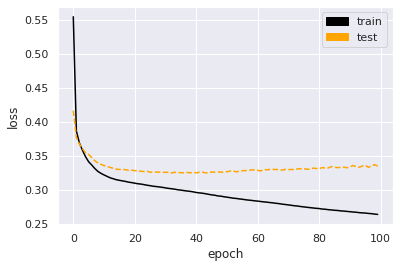

In [187]:
plot_history(history_to_df(ae_result))

In [188]:
prediction_encoder, prediction_decoder = extract_encoder_decoder(latent, 32, autoencoder)
train_recon = predict_data(prediction_encoder, prediction_decoder, normalized_train)
test_recon = predict_data(prediction_encoder, prediction_decoder, normalized_test)

<AxesSubplot:xlabel='data', ylabel='bc_distance'>

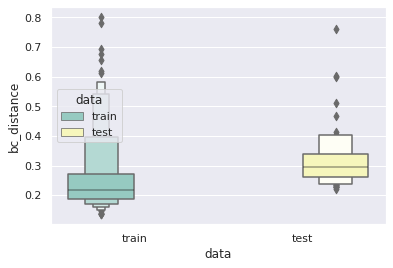

In [189]:
prediction_bc_train = calculate_BC(x_train, train_recon)
prediction_bc_train['data'] = 'train'
prediction_bc_test = calculate_BC(x_test, test_recon)
prediction_bc_test['data'] = 'test'

PREDICTION_BC = prediction_bc_train.append(prediction_bc_test)

sns.boxenplot(data = PREDICTION_BC, y = 'bc_distance', x = 'data', hue = 'data', palette = 'Set3')

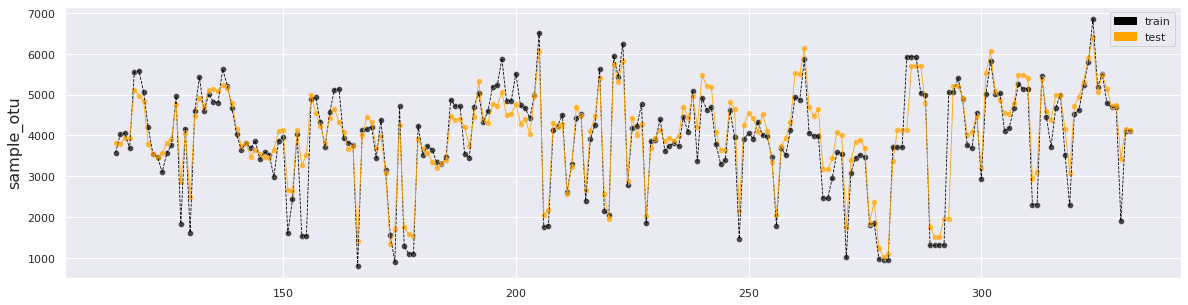

In [176]:
plot_sample_otu(x_train[1:],
                train_recon[:-1],
                'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG')

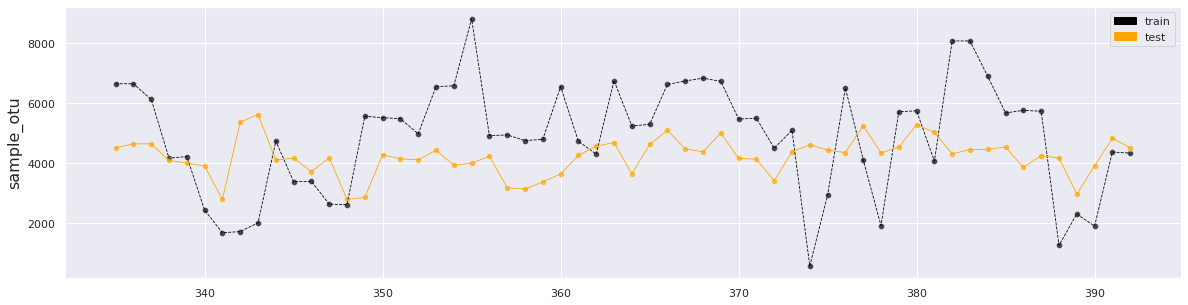

In [190]:
plot_sample_otu(x_test[1:],
                test_recon[:-1],
                'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG')

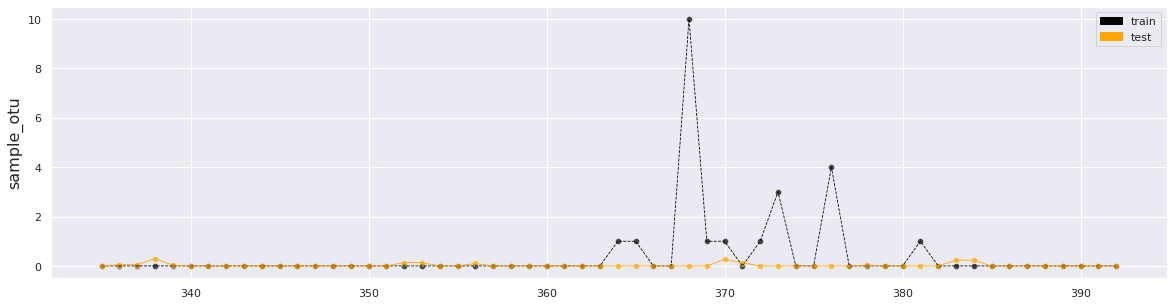

In [191]:
plot_sample_otu(x_test[1:],
                test_recon[:-1],
                'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGACTGGCAAGTCTGATGTGAAAGGCGGGGGCTCAACTCCTGGACTG')

# keras sVAR - mae loss

In [ ]:
units = 64
input_size = normalized_train.shape[1]
input_data = tf.keras.Input(shape=(input_size,))
#svar
svar_layer = tf.keras.layers.Dense(units, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))
svar_pred = svar_layer(input_data)
#output
output = tf.keras.layers.Dense(input_size)(svar_pred)
#model
svar_model = tf.keras.Model(input_data, output)

svar_model.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),   
    optimizer='Adam'
)
#train
svar_model_result = svar_model.fit(normalized_train[:-1], normalized_train[1:],
                                   epochs=100,
                                   batch_size=16,
                                   shuffle=False,
                                   validation_data=(normalized_test[:-1], normalized_test[1:]),
                                   verbose = 0
)

# keras svar - bray curtis loss

In [197]:
input_size = normalized_train.shape[1]
#input
input_data = tf.keras.Input(shape=(input_size,))
#svar layer
svar_layer = tf.keras.layers.Dense(64) #kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))
svar_pred = svar_layer(input_data)
#output
output = tf.keras.layers.Dense(input_size)(svar_pred)
#model
bc_svar_model = tf.keras.Model(input_data, output)

BrayCurtisLoss = LossBrayCurtis(None, None)
bc_svar_model.compile(
    loss = BrayCurtisLoss,   
    optimizer='Adam'
)
bc_svar_model.run_eagerly = True

#train
bc_svar_model_result = bc_svar_model.fit(normalized_train[:-1], normalized_train[1:],
                                   epochs=100,
                                   batch_size=16,
                                   shuffle=False,
                                   validation_data=(normalized_test[:-1], normalized_test[1:]),
                                   verbose = 0
)

In [200]:
bc_svar_model.predict(normalized_test)

array([[-0.19330086, -0.38647288, -0.5471856 , ..., -0.39725956,
        -0.15389737, -0.05938701],
       [-0.00906176, -0.35610762, -0.47436345, ..., -0.3303442 ,
         0.0935676 , -0.03838249],
       [-0.00906176, -0.35610762, -0.47436345, ..., -0.3303442 ,
         0.0935676 , -0.03838249],
       ...,
       [-0.38432804, -0.31332508, -0.8749118 , ..., -0.12201713,
        -0.51368886, -0.11266822],
       [-0.54335904, -0.28755027, -0.4446991 , ...,  0.15355729,
        -0.5817486 , -0.13607156],
       [-0.63881373, -0.200957  , -0.45210934, ...,  0.08292404,
        -0.47040153, -0.10628735]], dtype=float32)